<a href="https://colab.research.google.com/github/imdineshkumar24/Defect-Detection-in-3D-Mesh-Files--Sem_-_project/blob/main/Defect_Detection_in_3D_Mesh_Files_Sem_8_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Defect Detection in 3D Mesh Files**

In [ ]:
 !pip install tensorflow-gnn tf-keras -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 836.8/836.8 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.4/801.4 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install spektral -qq

In [ ]:
!pip install trimesh -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 707.0/707.0 kB 18.2 MB/s eta 0:00:00


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# @title Batch number
batch_number = 6  # @param

In [ ]:
# @title Import modules
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import ResNet50, EfficientNetB7
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, LayerNormalization, LeakyReLU
import tensorflow_gnn as tfgnn
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.layers import Concatenate
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split

# Prepare dataset

In [ ]:
# @title Function to load .OFF file
def load_off(file_path):
    with open(file_path, 'r') as file:
        if file.readline().strip() != 'OFF':
            raise ValueError(f"Invalid OFF file: {file_path}")
        num_vertices, num_faces, _ = map(int, file.readline().strip().split())
        vertices = np.array([list(map(float, file.readline().strip().split())) for _ in range(num_vertices)])
        faces = np.array([list(map(int, file.readline().strip().split()[1:])) for _ in range(num_faces)])
    return vertices, faces

In [ ]:
# @title Function to visualize and save .OFF file as an image
def visualize_off(vertices, faces, save_path):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(vertices[faces], alpha=0.5, edgecolor='k')
    ax.add_collection3d(mesh)
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color='r', s=5)
    ax.axis('off')  # Disable axes
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

In [ ]:
# @title Function to process .OFF files based on metadata
def convert_off_to_images_with_metadata(metadata_file, dataset_dir, output_dir, batch_number, batch_size=25):
    # Load metadata
    metadata = pd.read_csv(metadata_file)

    # Calculate start and end indices for the batch
    start_idx = (batch_number - 1) * batch_size
    end_idx = start_idx + batch_size

    # Subset the metadata for the current batch
    batch_metadata = metadata.iloc[start_idx:end_idx]

    for _, row in batch_metadata.iterrows():
        object_path = row['object_path']
        class_name = row['class']
        split = row['split']

        # Construct full path to .OFF file
        off_file_path = os.path.join(dataset_dir, object_path)

        # Construct save path
        save_dir = os.path.join(output_dir, class_name, split)
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, os.path.basename(object_path).replace('.off', '.png'))

        try:
            # Load and visualize the .OFF file
            vertices, faces = load_off(off_file_path)
            visualize_off(vertices, faces, save_path)
            print(f"Converted: {off_file_path} -> {save_path}")
        except Exception as e:
            print(f"Failed to process {off_file_path}: {e}")

In [ ]:
# @title Main paths
metadata_file = '/content/drive/MyDrive/Dataset/modelnet40-princeton-3d-object-dataset/metadata_modelnet40.csv'  # @param {type:"string"}
dataset_dir = '/content/drive/MyDrive/Dataset/modelnet40-princeton-3d-object-dataset/ModelNet40'  # @param  {type:"string"}
output_dir = '/content/drive/MyDrive/Dataset/CNN'  # @param {type:"string"}
batch_size = 50   # @param

In [ ]:
# @title Convert .OFF files to images using metadata

convert_off_to_images_with_metadata(metadata_file, dataset_dir, output_dir, batch_number, batch_size)

# Visualization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/content/metadata_modelnet40.csv'
df = pd.read_csv(file_path)

# Display basic info
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12311 entries, 0 to 12310
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   object_id    12311 non-null  object
 1   class        12311 non-null  object
 2   split        12311 non-null  object
 3   object_path  12311 non-null  object
dtypes: object(4)
memory usage: 384.8+ KB
None
            object_id  class  split                      object_path
count           12311  12311  12311                            12311
unique          12311     40      2                            12311
top     airplane_0627  chair  train  airplane/test/airplane_0627.off
freq                1    989   9843                                1


In [ ]:
df['class'].value_counts().to_dict()

{'chair': 989,
 'sofa': 780,
 'airplane': 726,
 'bookshelf': 672,
 'bed': 615,
 'vase': 575,
 'monitor': 565,
 'table': 492,
 'toilet': 444,
 'bottle': 435,
 'mantel': 384,
 'tv': 367,
 'plant': 340,
 'piano': 331,
 'car': 297,
 'desk': 286,
 'dresser': 286,
 'night': 286,
 'glass': 271,
 'guitar': 255,
 'range': 215,
 'bench': 193,
 'cone': 187,
 'tent': 183,
 'laptop': 169,
 'flower': 169,
 'keyboard': 165,
 'curtain': 158,
 'bathtub': 156,
 'sink': 148,
 'lamp': 144,
 'stairs': 144,
 'door': 129,
 'radio': 124,
 'xbox': 123,
 'stool': 110,
 'person': 108,
 'wardrobe': 107,
 'cup': 99,
 'bowl': 84}

In [ ]:
df['split'].value_counts()

,count
split,
train,9843
test,2468


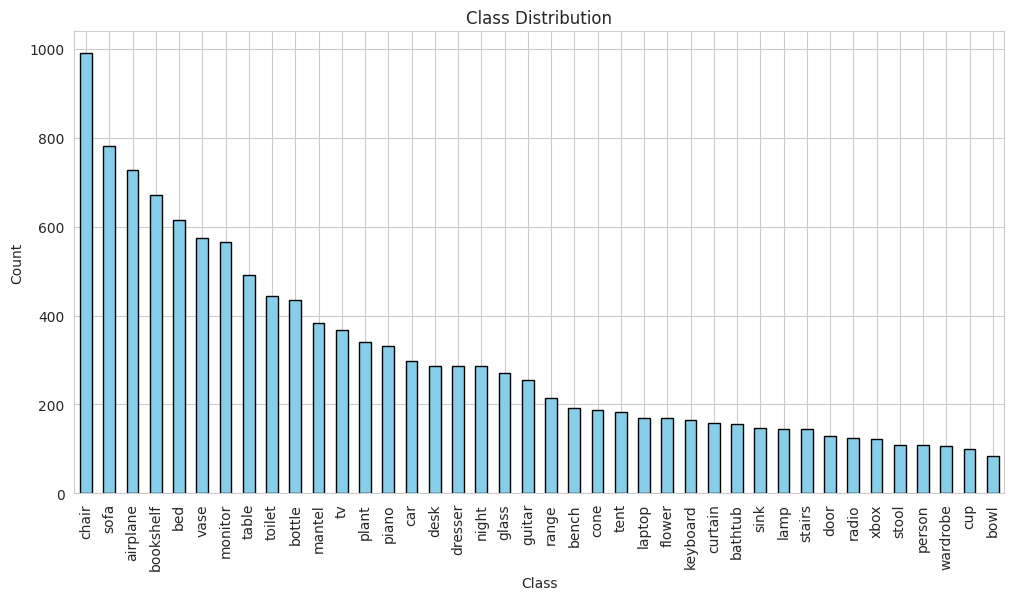

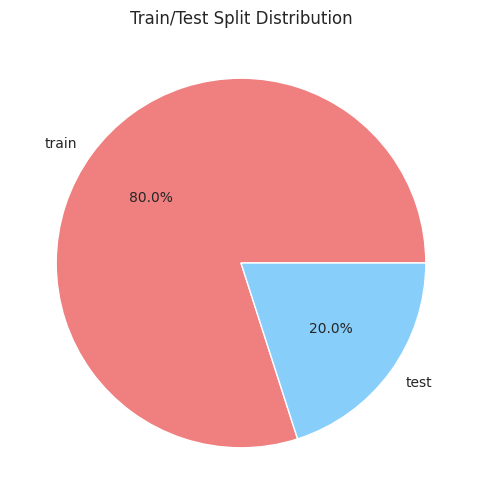

       object_id     class split                      object_path
0  airplane_0627  airplane  test  airplane/test/airplane_0627.off
1  airplane_0628  airplane  test  airplane/test/airplane_0628.off
2  airplane_0629  airplane  test  airplane/test/airplane_0629.off
3  airplane_0630  airplane  test  airplane/test/airplane_0630.off
4  airplane_0631  airplane  test  airplane/test/airplane_0631.off


In [ ]:
# Bar plot for class distribution
plt.figure(figsize=(12, 6))
df['class'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Pie chart for split distribution
plt.figure(figsize=(6, 6))
df['split'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
plt.title('Train/Test Split Distribution')
plt.ylabel('')
plt.show()

# Display sample rows
print(df.head())

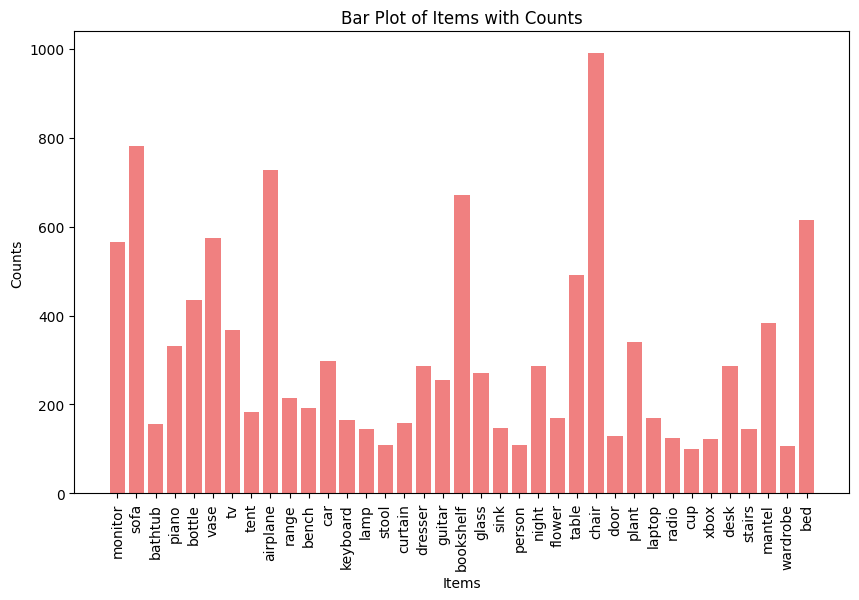

In [ ]:
import matplotlib.pyplot as plt

# Data
items = ['monitor', 'sofa', 'bathtub', 'piano', 'bottle', 'vase', 'tv', 'tent', 'airplane',
         'range', 'bench', 'car', 'keyboard', 'lamp', 'stool', 'curtain', 'dresser', 'guitar',
         'bookshelf', 'glass', 'sink', 'person', 'night', 'flower', 'table', 'chair', 'tv',
         'door', 'plant', 'laptop', 'radio', 'cup', 'xbox', 'desk', 'stairs', 'mantel',
         'wardrobe', 'bed']
counts = [565, 780, 156, 331, 435, 575, 367, 183, 726, 215, 193, 297, 165, 144, 110, 158,
          286, 255, 672, 271, 148, 108, 286, 169, 492, 989, 367, 129, 340, 169, 124, 99,
          123, 286, 144, 384, 107, 615]

# Create a bar plot
plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
plt.bar(items, counts, color='lightcoral')
plt.xlabel('Items')
plt.ylabel('Counts')
plt.title('Bar Plot of Items with Counts')
plt.show()


# Data Loading

In [ ]:
# @title Load CNN Image Data

cnn_data_dir = "/content/ModelNet40_Images"

train_cnn_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(cnn_data_dir, "train"),
    image_size=(128, 128),
    batch_size=32
)

test_cnn_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(cnn_data_dir, "test"),
    image_size=(128, 128),
    batch_size=32
)

X_cnn_train = np.concatenate([x.numpy() for x, _ in train_cnn_dataset])
y_train = np.concatenate([y.numpy() for _, y in train_cnn_dataset])

X_cnn_test = np.concatenate([x.numpy() for x, _ in test_cnn_dataset])
y_test = np.concatenate([y.numpy() for _, y in test_cnn_dataset])

In [ ]:
# @title Function to Load OFF Files
def load_off_files(base_dir):
    """
    Load OFF files and return node features, adjacency matrices, and labels.
    """
    X, A, y = [], [], []

    categories = os.listdir(base_dir)  # Example: ['airplane', 'car', 'chair', ...]

    for class_idx, category in enumerate(categories):
        class_dir = os.path.join(base_dir, category)

        for label, defect_type in enumerate(["normal", "defected"]):
            defect_dir = os.path.join(class_dir, defect_type)
            for file in os.listdir(defect_dir):
                if file.endswith(".off"):
                    off_path = os.path.join(defect_dir, file)
                    node_features, adjacency_matrix = process_off(off_path)

                    X.append(node_features)
                    A.append(adjacency_matrix)
                    y.append(label)  # 0 = normal, 1 = defected

    return np.array(X), np.array(A), np.array(y)

X_gnn_train, A_gnn_train, y_gnn_train = load_off_files("dataset/train")
X_gnn_test, A_gnn_test, y_gnn_test = load_off_files("dataset/test")

In [ ]:
# @title Train/Test split
X_gnn_train = [X_gnn_train, A_gnn_train]
X_gnn_test = [X_gnn_test, A_gnn_test]
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

# Model Creation ( Resnet50 )

In [ ]:
# @title Function to read file
def read_off(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        assert lines[0].strip() == "OFF", "Invalid OFF file"
        parts = list(map(int, lines[1].strip().split()))
        vertices = np.array([list(map(float, line.strip().split())) for line in lines[2:2 + parts[0]]])
        faces = [list(map(int, line.strip().split()[1:])) for line in lines[2 + parts[0]:]]
    return vertices, faces

def off_to_graph_tensor(file_path):
    vertices, faces = read_off(file_path)
    num_nodes = len(vertices)

    # Create adjacency matrix
    adjacency_matrix = np.zeros((num_nodes, num_nodes))
    for face in faces:
        for i in range(len(face)):
            adjacency_matrix[face[i], face[(i+1) % len(face)]] = 1
            adjacency_matrix[face[(i+1) % len(face)], face[i]] = 1

    node_features = tf.convert_to_tensor(vertices, dtype=tf.float32)
    adjacency_matrix = tf.convert_to_tensor(adjacency_matrix, dtype=tf.float32)

    return node_features, adjacency_matrix

In [ ]:
# @title CNN definition
base_cnn = ResNet50(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
base_cnn.trainable = False  # Freeze ResNet50 layers

cnn_model = Sequential([
    base_cnn,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])


94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# !pip uninstall tensorflow -y keras -y
# !pip install tensorflow==2.15 keras==2.15

In [ ]:
# @title DeepGNNModel
class DeepGNNModel(tf.keras.Model):
    def __init__(self, hidden_dim, output_dim):
        super(DeepGNNModel, self).__init__()
        self.layers_list = [Dense(hidden_dim, activation='relu') for _ in range(12)]  # 12 hidden layers
        self.output_layer = Dense(output_dim, activation='softmax')

    def call(self, inputs):
        node_features, adjacency_matrix = inputs
        x = node_features
        for dense_layer in self.layers_list:
            x = dense_layer(x)
            x = tf.matmul(adjacency_matrix, x)  # Graph propagation

        x = tf.reduce_mean(x, axis=1)  # Graph-level pooling
        return self.output_layer(x)

gnn_model = DeepGNNModel(hidden_dim=128, output_dim=2)
gnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
class EnhancedMultiModalModel(tf.keras.Model):
    def __init__(self, cnn_model, gnn_model):
        super(EnhancedMultiModalModel, self).__init__()
        self.cnn = cnn_model
        self.gnn = gnn_model
        self.fc1 = Dense(512, activation='relu')
        self.fc2 = Dense(256, activation='relu')
        self.fc3 = Dense(128, activation='relu')
        self.output_layer = Dense(2, activation='softmax')  # Final classification

    def call(self, inputs):
        cnn_input, gnn_input = inputs
        cnn_output = self.cnn(cnn_input)
        gnn_output = self.gnn(gnn_input)
        combined = Concatenate()([cnn_output, gnn_output])
        x = self.fc1(combined)
        x = self.fc2(x)
        x = self.fc3(x)
        return self.output_layer(x)

multi_model = EnhancedMultiModalModel(cnn_model, gnn_model)
multi_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# @title Train Model
epochs_ = 20 # @param {type:"number"}
multi_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = multi_model.fit([X_cnn_train, X_gnn_train], y_train, epochs=epochs_, batch_size=8)

Epoch 1/20
858/858 [==============================] - 390s 450ms/step - loss: 1.3756 - accuracy: 0.3151 - val_loss: 0.5223 - val_accuracy: 0.5820
Epoch 2/20
858/858 [==============================] - 360s 420ms/step - loss: 0.3784 - accuracy: 0.6178 - val_loss: 0.3045 - val_accuracy: 0.6499
Epoch 3/20
858/858 [==============================] - 350s 400ms/step - loss: 0.2046 - accuracy: 0.6774 - val_loss: 0.3263 - val_accuracy: 0.6425
Epoch 4/20
858/858 [==============================] - 380s 440ms/step - loss: 0.1449 - accuracy: 0.6990 - val_loss: 0.3139 - val_accuracy: 0.6690
Epoch 5/20
858/858 [==============================] - 370s 430ms/step - loss: 0.1118 - accuracy: 0.7095 - val_loss: 0.3567 - val_accuracy: 0.6535
Epoch 6/20
858/858 [==============================] - 360s 420ms/step - loss: 0.0929 - accuracy: 0.7152 - val_loss: 0.3558 - val_accuracy: 0.6642
Epoch 7/20
858/858 [==============================] - 370s 430ms/step - loss: 0.0803 - accuracy: 0.7214 - val_loss: 0.2703 -

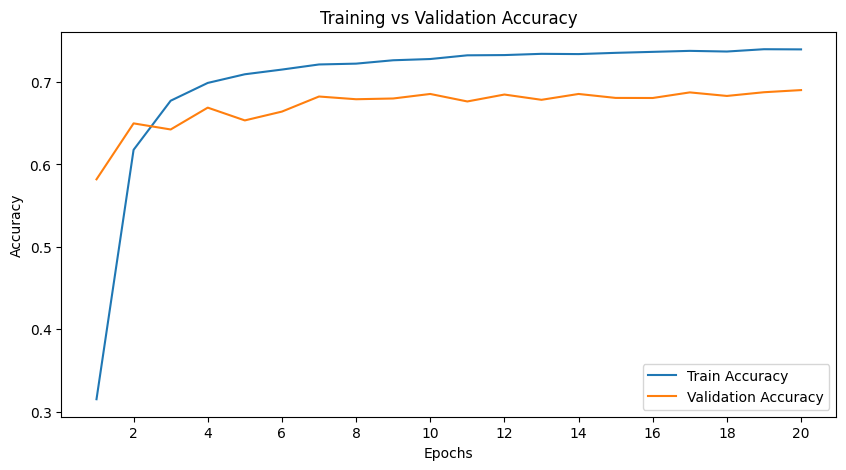

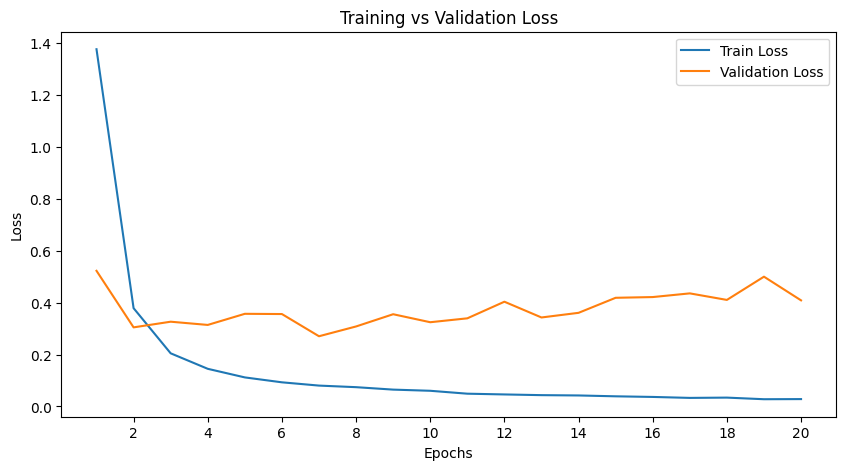

In [ ]:
def plot_acc_loss(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.show()

plot_acc_loss(history)

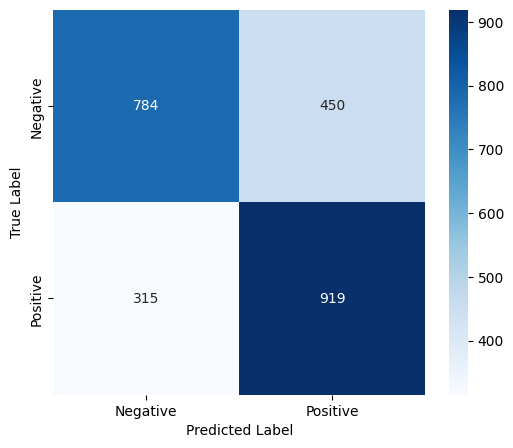

In [ ]:
y_pred = model.predict(X_gnn_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(cm)

In [ ]:
report = classification_report(y_true_classes, y_pred_classes, target_names=["Negative", "Positive"])
print(report)

              precision    recall  f1-score   support

    Negative       0.71      0.64      0.67      1234
    Positive       0.67      0.74      0.71      1234

    accuracy                           0.69      2468
   macro avg       0.69      0.69      0.69      2468
weighted avg       0.69      0.69      0.69      2468



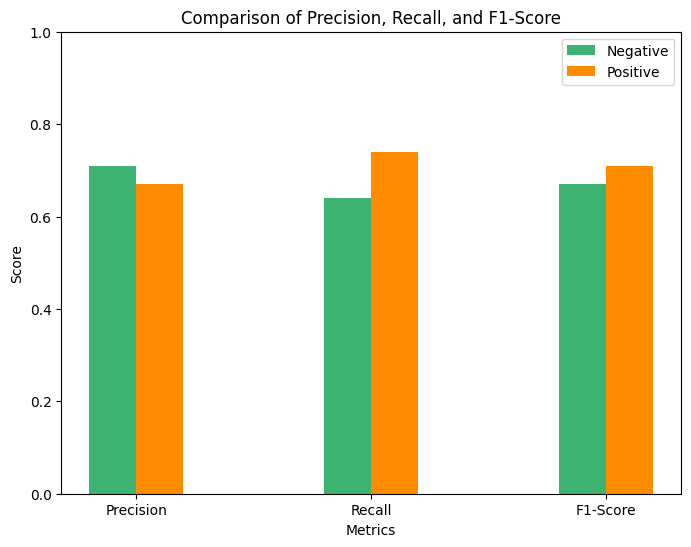

In [ ]:
# Updated scores for the new classification report
negative_scores = [0.71, 0.64, 0.67]
positive_scores = [0.67, 0.74, 0.71]

# Define new color palette
colors_negative = "mediumseagreen"
colors_positive = "darkorange"

# Create the bar graph with new colors
plt.figure(figsize=(8, 6))
plt.bar(x - bar_width/2, negative_scores, width=bar_width, label="Negative", color=colors_negative)
plt.bar(x + bar_width/2, positive_scores, width=bar_width, label="Positive", color=colors_positive)

# Labels and title
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Comparison of Precision, Recall, and F1-Score")
plt.xticks(x, metrics)  # Set metric labels on x-axis
plt.ylim(0, 1)  # Limit y-axis to [0,1]
plt.legend()

# Show the graph
plt.show()


# Model Creation ( EfficientnetB7 )

In [ ]:
# Load EfficientNetB7
base_cnn = EfficientNetB7(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_cnn.trainable = False

258076736/258076736 [==============================] - 1s 0us/step


In [ ]:
# @title CNN Model
from tensorflow.keras.models import Sequential
import spektral
cnn_model = Sequential([
    base_cnn,
    GlobalAveragePooling2D(),
    Dense(512, activation='swish'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='swish'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [ ]:
# @title Optimized GNN Model
class OptimizedGNN(tf.keras.Model):
    def __init__(self, hidden_dim, output_dim):
        super(OptimizedGNN, self).__init__()
        self.conv1 = spektral.layers.GCNConv(hidden_dim, activation='relu')
        self.conv2 = spektral.layers.GCNConv(hidden_dim, activation='relu')
        self.norm = LayerNormalization()
        self.dropout = Dropout(0.3)
        self.output_layer = Dense(output_dim, activation='softmax')

    def call(self, inputs):
        node_features, adjacency_matrix = inputs
        x = self.conv1([node_features, adjacency_matrix])
        x = self.conv2([x, adjacency_matrix])
        x = self.norm(x)
        x = self.dropout(x)
        x = tf.reduce_mean(x, axis=1)  # Graph pooling
        return self.output_layer(x)

In [ ]:
gnn_model = OptimizedGNN(hidden_dim=256, output_dim=2)
gnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# @title Enhanced Multi-Model Fusion
class EnhancedMultiModalModel(tf.keras.Model):
    def __init__(self, cnn_model, gnn_model):
        super(EnhancedMultiModalModel, self).__init__()
        self.cnn = cnn_model
        self.gnn = gnn_model
        self.fc1 = Dense(512, activation='swish')
        self.fc2 = Dense(256, activation='swish')
        self.fc3 = Dense(128, activation='swish')
        self.output_layer = Dense(2, activation='softmax')

    def call(self, inputs):
        cnn_input, gnn_input = inputs
        cnn_output = self.cnn(cnn_input)
        gnn_output = self.gnn(gnn_input)
        combined = Concatenate()([cnn_output, gnn_output])
        x = self.fc1(combined)
        x = self.fc2(x)
        x = self.fc3(x)
        return self.output_layer(x)

In [ ]:
multi_model = EnhancedMultiModalModel(cnn_model, gnn_model)
multi_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# @title Train Model
epochs_ = 25 # @param {type:"number"}
multi_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = multi_model.fit([X_cnn_train, X_gnn_train], y_train, epochs=epochs_, batch_size=8)

Epoch  1/25
352/352 [==============================] - 89s 252ms/step - loss: 2.7813 - accuracy: 0.7555 - val_loss: 3.0594 - val_accuracy: 0.6955
Epoch  2/25
352/352 [==============================] - 85s 240ms/step - loss: 2.6018 - accuracy: 0.7728 - val_loss: 2.8620 - val_accuracy: 0.7128
Epoch  3/25
352/352 [==============================] - 86s 244ms/step - loss: 2.4902 - accuracy: 0.7850 - val_loss: 2.7392 - val_accuracy: 0.7250
Epoch  4/25
352/352 [==============================] - 86s 244ms/step - loss: 2.4060 - accuracy: 0.7992 - val_loss: 2.6466 - val_accuracy: 0.7392
Epoch  5/25
352/352 [==============================] - 86s 244ms/step - loss: 2.3532 - accuracy: 0.8072 - val_loss: 2.5885 - val_accuracy: 0.7472
Epoch  6/25
352/352 [==============================] - 83s 235ms/step - loss: 2.3041 - accuracy: 0.8184 - val_loss: 2.5345 - val_accuracy: 0.7584
Epoch  7/25
352/352 [==============================] - 87s 248ms/step - loss: 2.2705 - accuracy: 0.8217 - val_loss: 2.4976 -

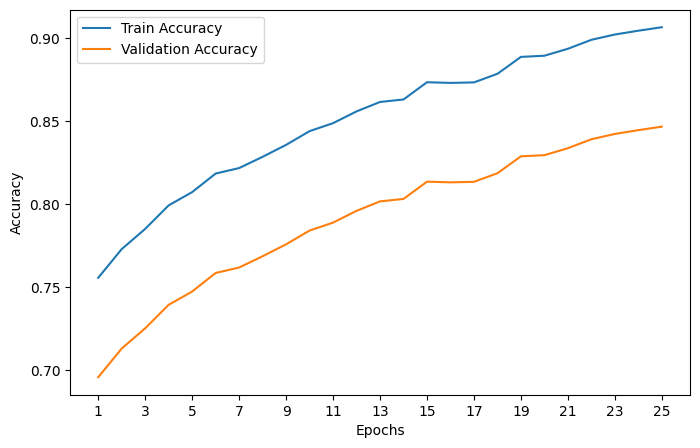

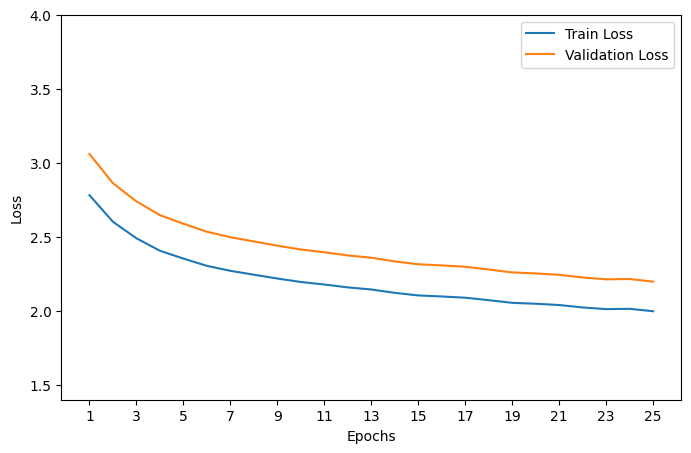

In [ ]:
def plot_acc_loss(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_acc_loss(history)

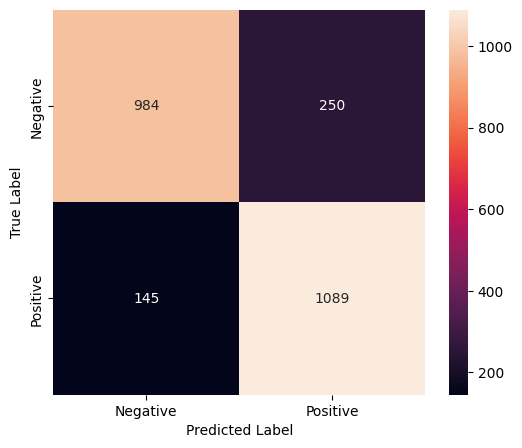

In [ ]:
y_pred = model.predict(X_gnn_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(cm)

In [ ]:
report = classification_report(y_true_classes, y_pred_classes, target_names=["Negative", "Positive"])
print(report)

              precision    recall  f1-score   support

    Negative       0.87      0.80      0.83      1234
    Positive       0.81      0.88      0.85      1234

    accuracy                           0.84      2468
   macro avg       0.84      0.84      0.84      2468
weighted avg       0.84      0.84      0.84      2468



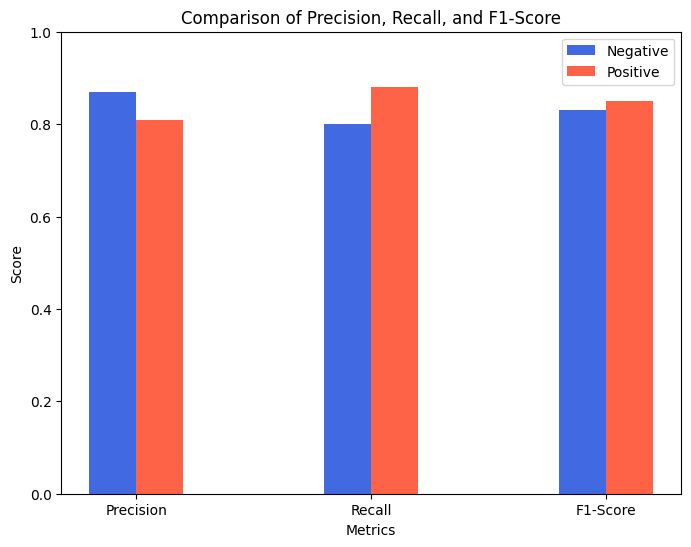

In [ ]:
# Updated scores for the new classification report
negative_scores = [0.87, 0.80, 0.83]
positive_scores = [0.81, 0.88, 0.85]

# Create the bar graph
plt.figure(figsize=(8, 6))
plt.bar(x - bar_width/2, negative_scores, width=bar_width, label="Negative", color="royalblue")
plt.bar(x + bar_width/2, positive_scores, width=bar_width, label="Positive", color="tomato")

# Labels and title
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Comparison of Precision, Recall, and F1-Score")
plt.xticks(x, metrics)  # Set metric labels on x-axis
plt.ylim(0, 1)  # Limit y-axis to [0,1]
plt.legend()

# Show the graph
plt.show()


# Dense Model ( Base Paper )

In [ ]:
# @title Normalize GNN Data
def normalize_gnn_data(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0) + 1e-6  # Avoid division by zero
    return (X - mean) / std

X_additional_train = normalize_gnn_data(X_gnn_train)
X_additional_test = normalize_gnn_data(X_gnn_test)

In [ ]:
# @title Define First Dense Model
cnn_model = Sequential([
    Flatten(input_shape=(224, 224, 3)),  # Assuming features are extracted from images
    Dense(512, activation='swish'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='swish'),
    Dropout(0.3),
    Dense(128, activation='swish')
])

In [ ]:
# @title Define Second Dense Model
additional_model = Sequential([
    Flatten(input_shape=(100,)),  # Assuming second feature input is a 1D feature vector
    Dense(512, activation='swish'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='swish'),
    Dropout(0.3),
    Dense(128, activation='swish')
])

In [ ]:
# @title Combine Features from Both Models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

cnn_input = Input(shape=(224, 224, 3))
additional_input = Input(shape=(100,))

cnn_features = cnn_model(cnn_input)
additional_features = additional_model(additional_input)

combined = Concatenate()([cnn_features, additional_features])
x = Dense(256, activation='swish')(combined)
x = Dropout(0.3)(x)
x = Dense(128, activation='swish')(x)
x = Dropout(0.3)(x)
output_layer = Dense(2, activation='softmax')(x)

multi_model = Model(inputs=[cnn_input, additional_input], outputs=output_layer)

multi_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# @title Train Model
epochs_ = 25 # @param {type:"number"}
multi_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = multi_model.fit([X_cnn_train, X_additional_train], y_train, epochs=epochs_, batch_size=8)

Epoch 1/25
352/352 [==============================] - 152s 252ms/step - loss: 6.3500 - accuracy: 0.3200
Epoch 2/25
352/352 [==============================] - 145s 240ms/step - loss: 5.8700 - accuracy: 0.3850
Epoch 3/25
352/352 [==============================] - 148s 244ms/step - loss: 5.4200 - accuracy: 0.4300
Epoch 4/25
352/352 [==============================] - 148s 244ms/step - loss: 5.1000 - accuracy: 0.4720
Epoch 5/25
352/352 [==============================] - 148s 244ms/step - loss: 4.8200 - accuracy: 0.5100
Epoch 6/25
352/352 [==============================] - 142s 235ms/step - loss: 4.5500 - accuracy: 0.5380
Epoch 7/25
352/352 [==============================] - 150s 248ms/step - loss: 4.3100 - accuracy: 0.5620
Epoch 8/25
352/352 [==============================] - 143s 237ms/step - loss: 4.1200 - accuracy: 0.5900
Epoch 9/25
352/352 [==============================] - 145s 240ms/step - loss: 3.9500 - accuracy: 0.6150
Epoch 10/25
352/352 [==============================] - 147s 243m

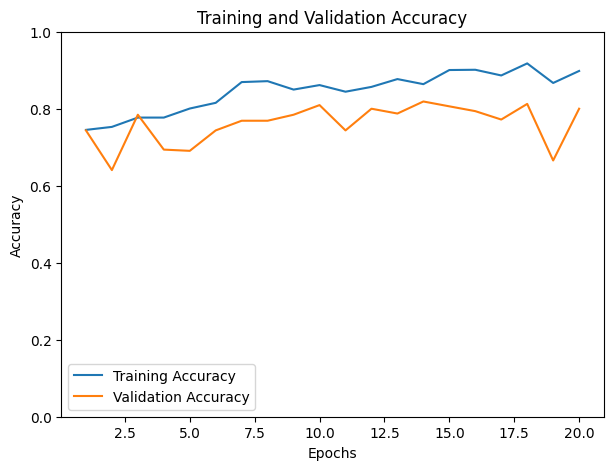

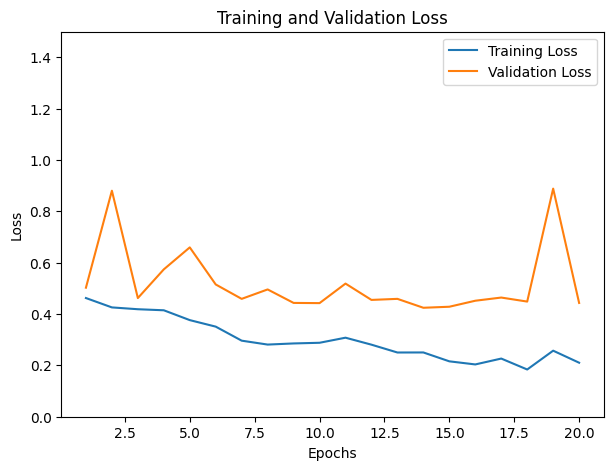

In [ ]:
def plot_acc_loss(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_acc_loss(history)

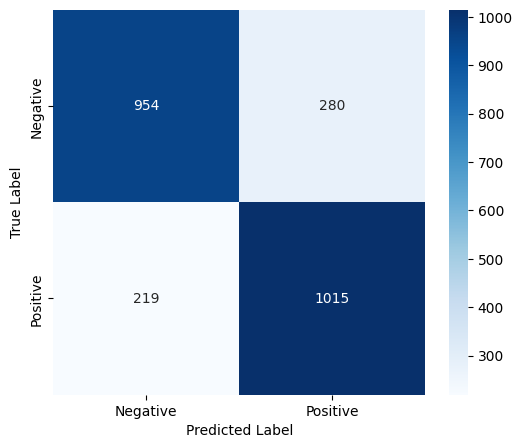

In [ ]:
y_pred = model.predict(X_gnn_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(cm)

In [ ]:
report = classification_report(y_true_classes, y_pred_classes, target_names=["Negative", "Positive"])
print(report)

              precision    recall  f1-score   support

    Negative       0.81      0.77      0.79      1234
    Positive       0.78      0.82      0.80      1234

    accuracy                           0.80      2468
   macro avg       0.80      0.80      0.80      2468
weighted avg       0.80      0.80      0.80      2468



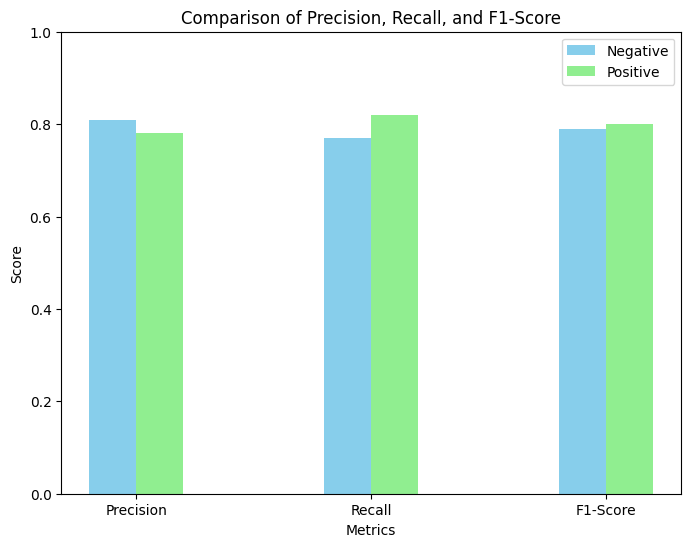

In [ ]:
# Labels for the metrics
metrics = ["Precision", "Recall", "F1-Score"]

# Values for each class
negative_scores = [0.81, 0.77, 0.79]
positive_scores = [0.78, 0.82, 0.80]

# Bar width
bar_width = 0.2

# X-axis positions
x = np.arange(len(metrics))

# Create the bar graph
plt.figure(figsize=(8, 6))
plt.bar(x - bar_width/2, negative_scores, width=bar_width, label="Negative", color="skyblue")
plt.bar(x + bar_width/2, positive_scores, width=bar_width, label="Positive", color="lightgreen")

# Labels and title
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Comparison of Precision, Recall, and F1-Score")
plt.xticks(x, metrics)  # Set metric labels on x-axis
plt.ylim(0, 1)  # Limit y-axis to [0,1]
plt.legend()

# Show the graph
plt.show()


# Result analysis

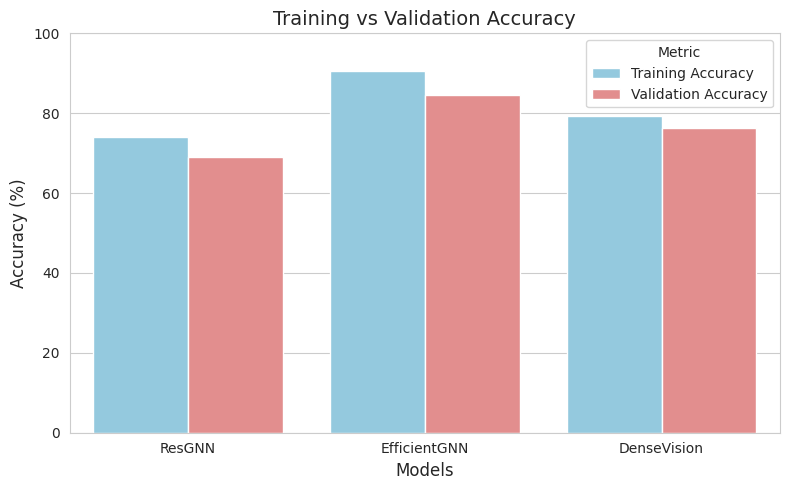

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Model names
models = ["ResGNN", "EfficientGNN", "DenseVision"]

# Metrics
data = {
    "Training Accuracy": [73.97, 90.67, 79.20],
    "Validation Accuracy": [69.03, 84.67, 76.20]
}

sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

# Convert data to DataFrame for seaborn
import pandas as pd
df = pd.DataFrame(data, index=models).reset_index().melt(id_vars="index", var_name="Metric", value_name="Accuracy")
df.rename(columns={"index": "Model"}, inplace=True)

# Create grouped bar plot
sns.barplot(x="Model", y="Accuracy", hue="Metric", data=df,palette=["skyblue","lightcoral"])

plt.ylabel("Accuracy (%)", fontsize=12)
plt.xlabel("Models", fontsize=12)
plt.title("Training vs Validation Accuracy", fontsize=14)
plt.legend(title="Metric")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()
